# MLP Character-Level Language Model

## Part 1: Setup

In [2]:
# Imports
import sys
sys.path.append('..') 

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import mlflow
import random
from tqdm import tqdm
import os

# Import our data utilities
from src.data_utils import load_dataset

# Set random seeds for reproducibility
RANDOM_SEED = 2147483647
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

print("Imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

Imports successful!
PyTorch version: 2.5.1
Device: cpu


### Hyperparameters

In [3]:
# Hyperparameters
block_size = 3          # Context window: how many characters to look at
embedding_dim = 10      # Dimension of character embeddings
hidden_size = 200       # Number of neurons in hidden layer
learning_rate = 0.1     # Step size for gradient descent
num_steps = 20000       # Number of training iterations

## Part 2: Load Data

In [4]:
# Load dataset
dataset = load_dataset('../data/processed/names_group3.txt')

print(f"\nVocabulary: {dataset.chars}")
print(f"Vocabulary size: {dataset.vocab_size}")

Loaded 102,450 names from names_group3.txt
Vocabulary size: 27 characters
   Characters: abcdefghijklmnopqrstuvwxyz
Dataset splits:
   Train: 81,960 names (80%)
   Val:   10,245 names (10%)
   Test:  10,245 names (10%)

DATASET STATISTICS
Total names:    102,450
Train names:    81,960
Val names:      10,245
Test names:     10,245
Vocabulary:     27 characters
Name length:    min=2, max=15, avg=6.5


Vocabulary: ['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Vocabulary size: 27


## Part 3: Build Training Dataset

Unlike bigram, we now look at **multiple previous characters**.

Example with block_size=3 for name "emma":
```
Context      Target
[. . .]   →   e
[. . e]   →   m
[. e m]   →   m
[e m m]   →   a
[m m a]   →   .
```

In [5]:
def build_dataset(names, block_size, stoi):
    """
    Build dataset of context windows and targets.
    
    Args:
        names: List of names
        block_size: Number of previous characters to use as context
        stoi: Character to index mapping
        
    Returns:
        X: Context windows (input), shape (N, block_size)
        Y: Target characters (output), shape (N,)
    """
    X, Y = [], []
    
    for name in names:
       
        context = [stoi['.']] * block_size  
        
        for ch in name + '.':
            ix = stoi[ch]
            X.append(context.copy())  
            Y.append(ix)              
            context = context[1:] + [ix]  
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    return X, Y

# Build datasets for train, val, test
print("Building datasets...")
Xtr, Ytr = build_dataset(dataset.train_names, block_size, dataset.stoi)
Xval, Yval = build_dataset(dataset.val_names, block_size, dataset.stoi)
Xte, Yte = build_dataset(dataset.test_names, block_size, dataset.stoi)

print(f"\nDataset built:")
print(f"  Train: {Xtr.shape[0]:,} examples")
print(f"  Val:   {Xval.shape[0]:,} examples")
print(f"  Test:  {Xte.shape[0]:,} examples")
print(f"\n  Input shape (X):  {Xtr.shape}  (N, block_size)")
print(f"  Output shape (Y): {Ytr.shape}  (N,)")

Building datasets...

Dataset built:
  Train: 617,080 examples
  Val:   76,982 examples
  Test:  76,972 examples

  Input shape (X):  torch.Size([617080, 3])  (N, block_size)
  Output shape (Y): torch.Size([617080])  (N,)


### Visualize some examples

In [6]:
# Show first 10 examples
print("\nFirst 10 training examples:")
print("\nContext →  Target")
print("-" * 30)
for i in range(10):
    context = ''.join([dataset.itos[ix.item()] for ix in Xtr[i]])
    target = dataset.itos[Ytr[i].item()]
    print(f"[{context}]  →  {target}")


First 10 training examples:

Context →  Target
------------------------------
[...]  →  m
[..m]  →  a
[.ma]  →  k
[mak]  →  e
[ake]  →  n
[ken]  →  z
[enz]  →  i
[nzi]  →  e
[zie]  →  .
[...]  →  s


## Part 4: Initialize Model Parameters

Our MLP has 3 components:
1. **Embedding matrix C**: Maps each character to a vector
2. **Hidden layer W1, b1**: First layer with tanh activation
3. **Output layer W2, b2**: Final layer for predictions

In [7]:
# Initialize parameters
g = torch.Generator().manual_seed(RANDOM_SEED)

# Embedding matrix: each of 27 characters gets a 10-dimensional vector
C = torch.randn((dataset.vocab_size, embedding_dim), generator=g)

# Hidden layer: maps (block_size * embedding_dim) → hidden_size
W1 = torch.randn((block_size * embedding_dim, hidden_size), generator=g)
b1 = torch.randn(hidden_size, generator=g)

# Output layer: maps hidden_size → vocab_size
W2 = torch.randn((hidden_size, dataset.vocab_size), generator=g)
b2 = torch.randn(dataset.vocab_size, generator=g)

# Make all parameters require gradients
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

print("\nModel Architecture:")
print(f"  Embedding matrix C:    {C.shape} = {C.numel():,} parameters")
print(f"  Hidden layer W1:       {W1.shape} = {W1.numel():,} parameters")
print(f"  Hidden layer b1:       {b1.shape} = {b1.numel():,} parameters")
print(f"  Output layer W2:       {W2.shape} = {W2.numel():,} parameters")
print(f"  Output layer b2:       {b2.shape} = {b2.numel():,} parameters")
print(f"  " + "="*50)
print(f"  Total parameters:      {sum(p.numel() for p in parameters):,}")


Model Architecture:
  Embedding matrix C:    torch.Size([27, 10]) = 270 parameters
  Hidden layer W1:       torch.Size([30, 200]) = 6,000 parameters
  Hidden layer b1:       torch.Size([200]) = 200 parameters
  Output layer W2:       torch.Size([200, 27]) = 5,400 parameters
  Output layer b2:       torch.Size([27]) = 27 parameters
  Total parameters:      11,897


---
## Part 5: Training Loop

Train for 20,000 steps using mini-batch gradient descent.

In [8]:
# Track losses for plotting
losses = []
steps = []

print("\nStarting training...\n")

for i in tqdm(range(num_steps)):
    # Mini-batch: sample random examples
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # Forward pass
    emb = C[Xtr[ix]]  
    h = torch.tanh(emb.view(-1, block_size * embedding_dim) @ W1 + b1)  
    logits = h @ W2 + b2  
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update parameters
    for p in parameters:
        p.data += -learning_rate * p.grad
    
    # Track progress
    if i % 1000 == 0:
        losses.append(loss.item())
        steps.append(i)
    
    # Print progress every 2000 steps
    if i % 2000 == 0:
        print(f"Step {i:5d}: loss = {loss.item():.4f}")

print(f"\nTraining complete! Final loss: {loss.item():.4f}")


Starting training...



  3%|▎         | 604/20000 [00:00<00:09, 1971.26it/s]

Step     0: loss = 29.5155


 13%|█▎        | 2689/20000 [00:01<00:05, 3383.28it/s]

Step  2000: loss = 3.0473


 23%|██▎       | 4559/20000 [00:01<00:04, 3318.35it/s]

Step  4000: loss = 2.5818


 33%|███▎      | 6556/20000 [00:02<00:03, 3468.03it/s]

Step  6000: loss = 2.5510


 42%|████▏     | 8451/20000 [00:02<00:03, 3605.12it/s]

Step  8000: loss = 2.5710


 52%|█████▏    | 10485/20000 [00:03<00:02, 3880.25it/s]

Step 10000: loss = 2.6255


 63%|██████▎   | 12505/20000 [00:03<00:02, 3580.25it/s]

Step 12000: loss = 2.7060


 73%|███████▎  | 14666/20000 [00:04<00:01, 3353.43it/s]

Step 14000: loss = 2.2701


 83%|████████▎ | 16561/20000 [00:05<00:01, 3334.78it/s]

Step 16000: loss = 2.6725


 93%|█████████▎| 18533/20000 [00:05<00:00, 3738.29it/s]

Step 18000: loss = 2.0238


100%|██████████| 20000/20000 [00:06<00:00, 3297.22it/s]


Training complete! Final loss: 2.5384


## Part 6: Plot Training Loss

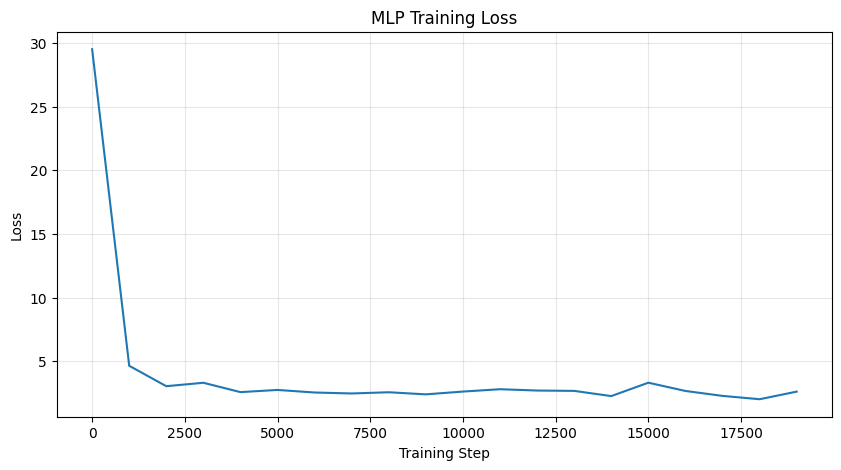

Loss curve saved to outputs/mlp_training_loss.png


In [9]:
plt.figure(figsize=(10, 5))
plt.plot(steps, losses)
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.title('MLP Training Loss')
plt.grid(True, alpha=0.3)
plt.savefig('../outputs/mlp_training_loss.png', dpi=100, bbox_inches='tight')
plt.show()

print("Loss curve saved to outputs/mlp_training_loss.png")

## Part 7: Evaluate on Train/Val Sets

In [10]:
@torch.no_grad()  # Don't compute gradients for evaluation
def eval_loss(X, Y):
    """
    Calculate average loss on a dataset.
    """
    emb = C[X]
    h = torch.tanh(emb.view(-1, block_size * embedding_dim) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    return loss.item()

# Calculate losses
train_loss = eval_loss(Xtr, Ytr)
val_loss = eval_loss(Xval, Yval)

print(f"\nFinal Performance:")
print(f"  Train Loss: {train_loss:.4f}")
print(f"  Val Loss:   {val_loss:.4f}")


Final Performance:
  Train Loss: 2.4867
  Val Loss:   2.4974


## Part 8: Generate Names

In [11]:
@torch.no_grad()
def generate_name(max_length=15):
    """
    Generate a single name using the trained MLP.
    """
    name = []
    context = [dataset.stoi['.']] * block_size  
    
    while True:
        # Forward pass
        x = torch.tensor([context])
        emb = C[x]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        
        # Sample next character
        ix = torch.multinomial(probs, num_samples=1).item()
        
        # Stop if we sample the end token
        if ix == dataset.stoi['.']:
            break
        
        # Add character to name
        name.append(dataset.itos[ix])
        context = context[1:] + [ix]  
        
        # Safety check
        if len(name) >= max_length:
            break
    
    return ''.join(name)

# Generate 30 names
print("\nGenerated names using MLP:\n")
generated_names = []
for i in range(30):
    name = generate_name()
    generated_names.append(name)
    print(f"{i+1:2d}. {name}")


Generated names using MLP:

 1. syye
 2. saylyy
 3. simeye
 4. avan
 5. dotti
 6. armiym
 7. ken
 8. katre
 9. days
10. tebon
11. cota
12. cowlyss
13. blanisi
14. aksis
15. iis
16. sah
17. artiyn
18. root
19. colystie
20. lequxlyanne
21. kear
22. nahplitterle
23. kanillyan
24. nubentellynaile
25. anjamer
26. maia
27. sablanjelia
28. akite
29. eva
30. anvillihmia


## Part 9: Visualize Character Embeddings

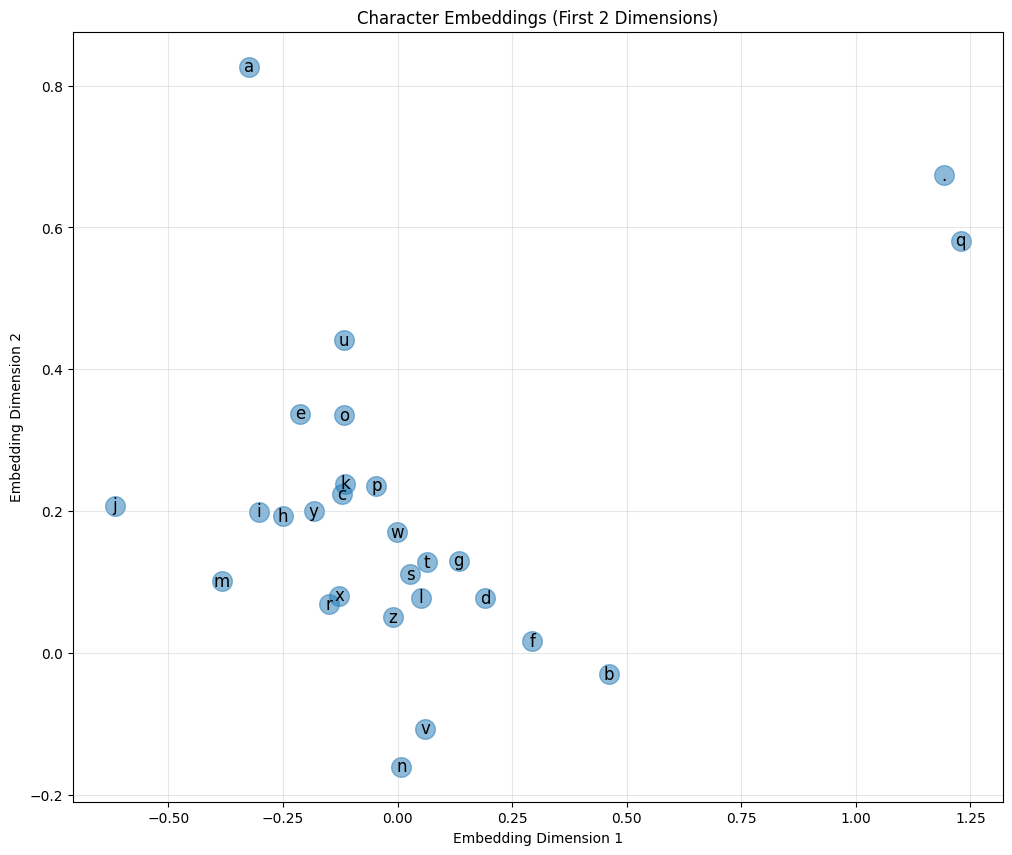

Embeddings visualization saved to outputs/mlp_embeddings.png


In [12]:
# Plot embeddings 
plt.figure(figsize=(12, 10))
plt.scatter(C[:,0].data, C[:,1].data, s=200, alpha=0.5)

# Label each point
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), dataset.itos[i], 
             ha='center', va='center', fontsize=12)

plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.title('Character Embeddings (First 2 Dimensions)')
plt.grid(True, alpha=0.3)
plt.savefig('../outputs/mlp_embeddings.png', dpi=100, bbox_inches='tight')
plt.show()

print("Embeddings visualization saved to outputs/mlp_embeddings.png")

## Part 10: Save Model

In [13]:
# Save model parameters
torch.save({
    'C': C,
    'W1': W1,
    'b1': b1,
    'W2': W2,
    'b2': b2,
    'hyperparameters': {
        'block_size': block_size,
        'embedding_dim': embedding_dim,
        'hidden_size': hidden_size,
        'learning_rate': learning_rate,
        'num_steps': num_steps,
    }
}, '../outputs/mlp_baseline_model.pth')

print("Model saved to outputs/mlp_baseline_model.pth")

Model saved to outputs/mlp_baseline_model.pth


## Part 11: Log to MLflow

In [14]:
# Configure MLflow
mlflow_tracking_uri = f"file://{os.path.abspath('../mlruns')}"
mlflow.set_tracking_uri(mlflow_tracking_uri)
mlflow.set_experiment("makemore-mlp")

with mlflow.start_run(run_name="mlp_baseline"):
    # Log hyperparameters
    mlflow.log_param("model_type", "mlp")
    mlflow.log_param("block_size", block_size)
    mlflow.log_param("embedding_dim", embedding_dim)
    mlflow.log_param("hidden_size", hidden_size)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("num_steps", num_steps)
    mlflow.log_param("num_parameters", sum(p.numel() for p in parameters))
    mlflow.log_param("random_seed", RANDOM_SEED)
    
    # Log metrics
    mlflow.log_metric("train_loss", train_loss)
    mlflow.log_metric("val_loss", val_loss)
    mlflow.log_metric("final_train_loss", losses[-1])
    
    # Log artifacts
    mlflow.log_artifact("../outputs/mlp_training_loss.png")
    mlflow.log_artifact("../outputs/mlp_embeddings.png")
    mlflow.log_artifact("../outputs/mlp_baseline_model.pth")
    
    # Save generated names
    with open('../outputs/mlp_generated_names.txt', 'w') as f:
        for name in generated_names:
            f.write(name + '\n')
    mlflow.log_artifact("../outputs/mlp_generated_names.txt")
    
    print("Logged to MLflow!")

print("\nAll done! Check MLflow UI at http://127.0.0.1:5000")
print("   Look for experiment: makemore-mlp")

Logged to MLflow!

All done! Check MLflow UI at http://127.0.0.1:5000
   Look for experiment: makemore-mlp
